In [27]:
print("Hello world")

Hello world


In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
import tarfile
import os

# Replace with your actual path from Input tab
archive_path = "/kaggle/input/datasets/aayushsah171/cifar-10-dataset-01/data.tar.xz"

extract_path = "/kaggle/working/data"

os.makedirs(extract_path, exist_ok=True)

with tarfile.open(archive_path, "r:xz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

/tmp/ipykernel_55/4188641852.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Extraction complete.


In [17]:
import os

print(os.listdir("/kaggle/working/data/data"))

['cifar10', 'info']


In [18]:
# =============================
# Data Loading + Augmentation
# =============================

DATA_DIR = "/kaggle/working/data/data/cifar10"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [19]:
# =============================
# Residual Block Definition
# =============================

def residual_block(x, filters, downsample=False):
    shortcut = x

    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, (3,3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


In [20]:
# =============================
# Build ResNet-style Model
# =============================

inputs = layers.Input(shape=(32,32,3))

x = layers.Conv2D(32, (3,3), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Residual Blocks
x = residual_block(x, 32)
x = residual_block(x, 32)

x = residual_block(x, 64, downsample=True)
x = residual_block(x, 64)

x = residual_block(x, 128, downsample=True)
x = residual_block(x, 128)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()


I0000 00:00:1772290816.516879      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772290816.523110      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 717,002 (2.74 MB)

 Trainable params: 714,506 (2.73 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [21]:
# =============================
# Compile
# =============================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
# =============================
# Callbacks
# =============================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [23]:
# =============================
# Train
# =============================

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1772290826.961695     175 service.cc:152] XLA service 0x7e8dac017290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772290826.961732     175 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1772290826.961738     175 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1772290828.685308     175 cuda_dnn.cc:529] Loaded cuDNN version 91002


   5/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.1029 - loss: 2.7553 

I0000 00:00:1772290835.482059     175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 36ms/step - accuracy: 0.3153 - loss: 1.9172 - val_accuracy: 0.4137 - val_loss: 1.8554 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.5725 - loss: 1.1993 - val_accuracy: 0.5849 - val_loss: 1.2310 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6484 - loss: 1.0053 - val_accuracy: 0.5731 - val_loss: 1.3340 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6998 - loss: 0.8740 - val_accuracy: 0.6866 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7358 - loss: 0.7773 - val_accuracy: 0.6755 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7543 - loss: 0.7168 - val_accuracy: 0.7238 - val_loss: 0.8700 - learning_rate: 0.0010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.7826 

In [24]:
# =============================
# Evaluation
# =============================

test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9004 - loss: 0.2961
Test Accuracy: 0.9007999897003174


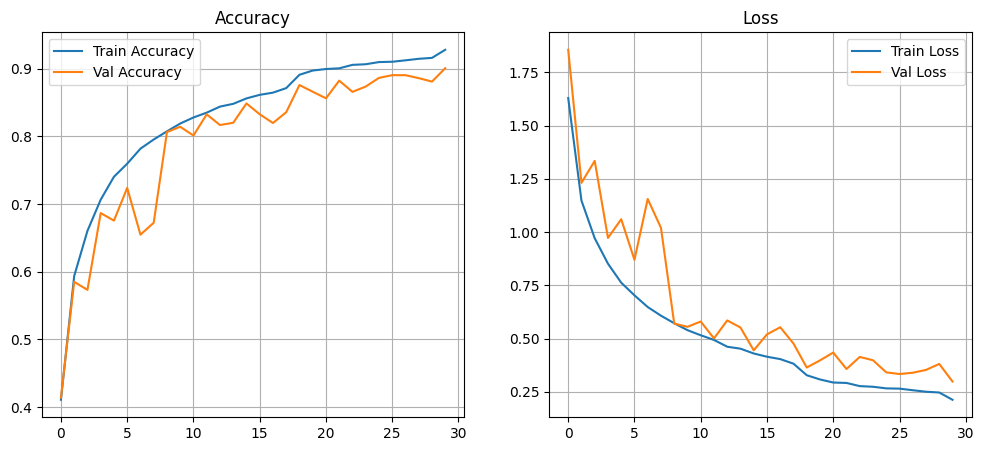

In [25]:
# =============================
# Plot Curves
# =============================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.grid(True)
plt.legend()

plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


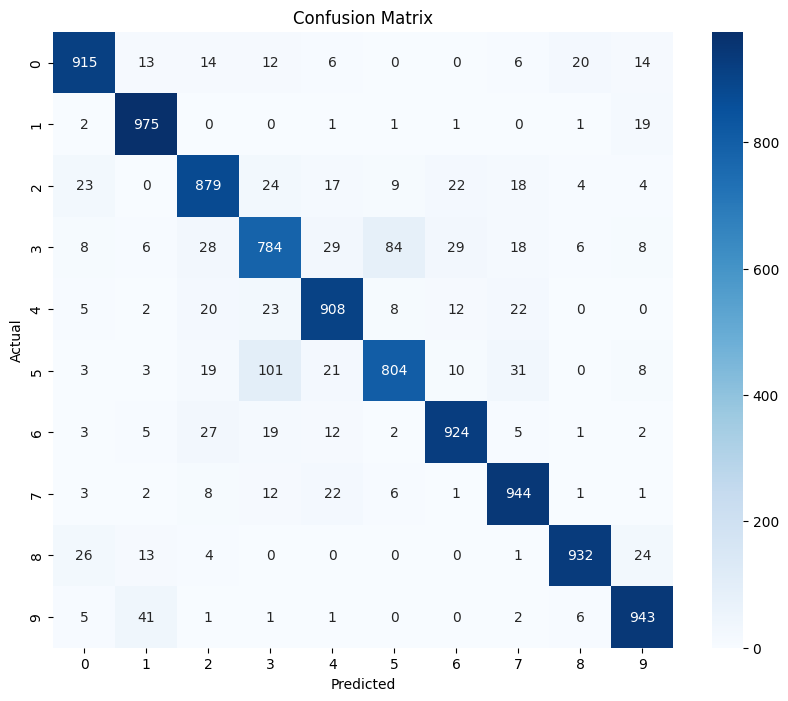

In [26]:
# =============================
# Confusion Matrix
# =============================

test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
